In [57]:
import pystan
import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

import statsmodels.api as sm
from scipy import signal

In [5]:
kilo10000 = pd.read_csv("../data/kilo10000_interpolate.csv")
kilo10000.head()

,date,キロ程,高低左,高低右,通り左,通り右,水準,軌間,速度
0,2017-04-01,10000,-1.16,-0.230,1.20,1.20,0.83,3.890,84.0
1,2017-04-02,10000,-0.81,-0.160,2.40,2.40,1.11,4.140,84.0
2,2017-04-03,10000,-0.99,-0.220,2.37,2.37,0.50,3.910,84.0
3,2017-04-04,10000,-0.98,-0.275,2.44,2.55,0.50,3.595,54.0
4,2017-04-05,10000,-0.97,-0.330,2.51,2.73,0.50,3.280,45.0


In [6]:
kilo10001 = pd.read_csv("../data/kilo10001_interpolate.csv")
kilo10002 = pd.read_csv("../data/kilo10002_interpolate.csv")
kilo10003 = pd.read_csv("../data/kilo10003_interpolate.csv")
kilo10004 = pd.read_csv("../data/kilo10004_interpolate.csv")


In [23]:
data = pd.concat((kilo10000["高低左"],kilo10001["高低左"],kilo10002["高低左"],kilo10003["高低左"],kilo10004["高低左"]), axis=1)
data.columns = ["10000","10001","10002","10003","10004"]
data.index = kilo10000["date"].values
data

,10000,10001,10002,10003,10004
2017-04-01,-1.160000,-1.170000,-1.090000,-0.640000,0.470000
2017-04-02,-0.810000,-0.830000,-0.710000,-0.150000,1.010000
2017-04-03,-0.990000,-0.910000,-0.670000,-0.020000,1.220000
2017-04-04,-0.980000,-0.810000,-0.500000,0.180000,1.385000
2017-04-05,-0.970000,-0.710000,-0.330000,0.380000,1.550000
2017-04-06,-1.480000,-1.070000,-0.290000,0.950000,2.630000
2017-04-07,-0.660000,-0.560000,-0.460000,-0.100000,0.820000
2017-04-08,-1.290000,-0.980000,-0.560000,0.150000,1.300000
2017-04-09,-0.980000,-0.820000,-0.620000,-0.130000,0.870000
2017-04-10,-1.630000,-1.450000,-1.060000,-0.240000,1.160000


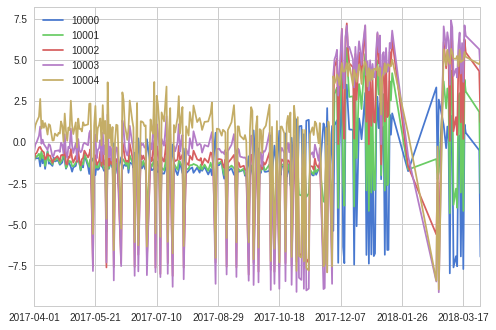

In [30]:
#時間軸でプロット
data.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ffd0aefd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2ffcee9c18>]], dtype=object)

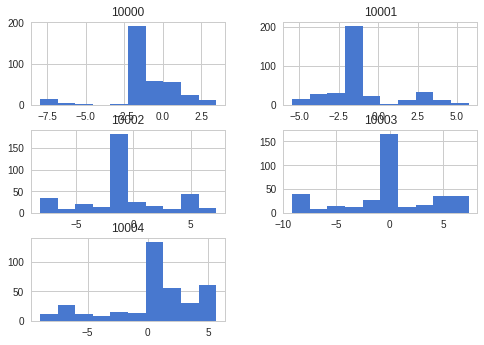

In [32]:
#ヒストグラム
data.hist()

In [35]:
#五数要約
data.describe()

,10000,10001,10002,10003,10004
count,365.000000,365.000000,365.000000,365.000000,365.000000
mean,-1.072932,-1.026110,-0.772726,-0.229260,0.593027
std,1.963076,2.165904,3.476691,4.130872,3.482560
min,-7.990000,-5.450000,-8.150000,-9.140000,-8.970000
25%,-1.750000,-1.790000,-1.510000,-0.950000,0.100000
50%,-1.330000,-1.420000,-1.050000,-0.270000,1.030000
75%,0.083636,-1.010000,-0.040000,1.500769,2.630000
max,3.500000,5.740000,7.230000,7.410000,5.680000


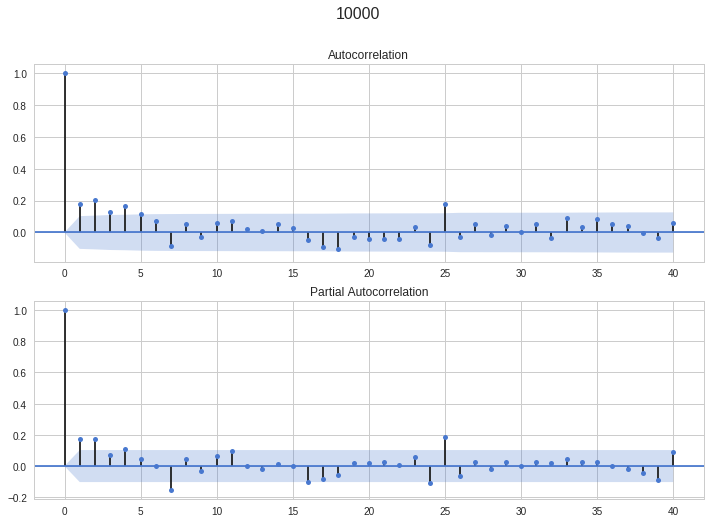

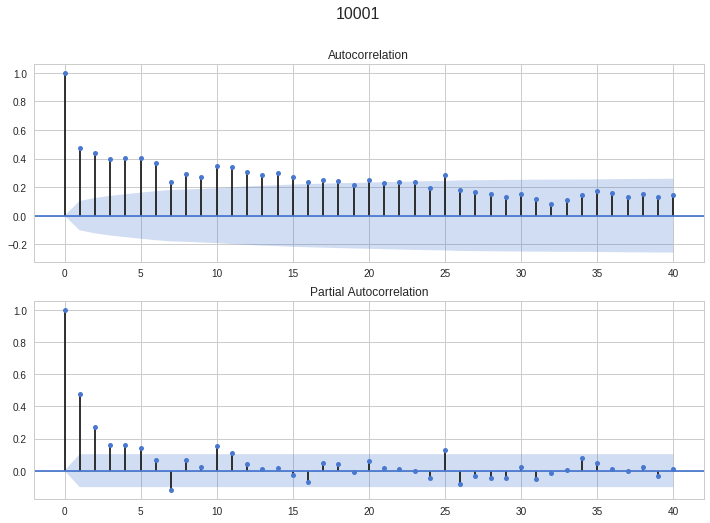

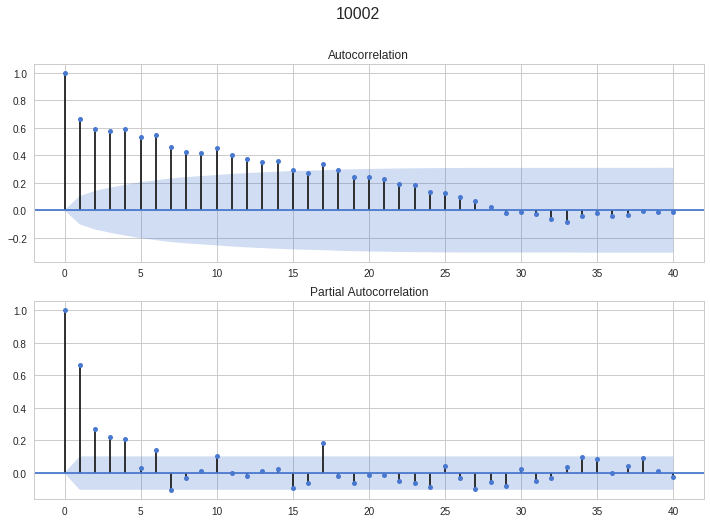

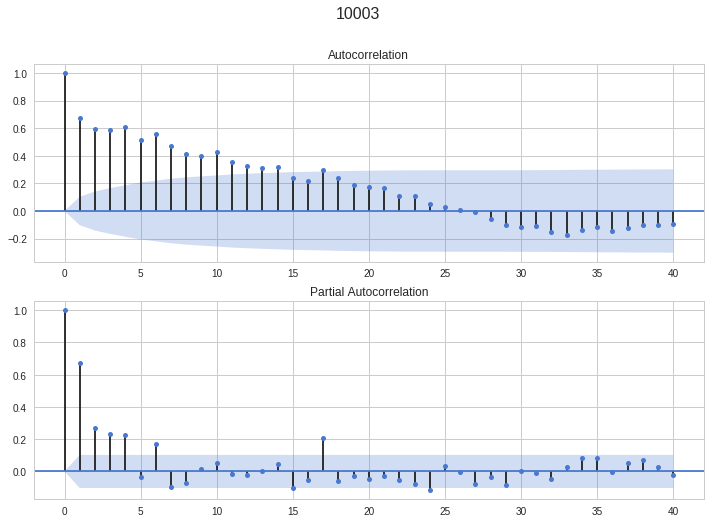

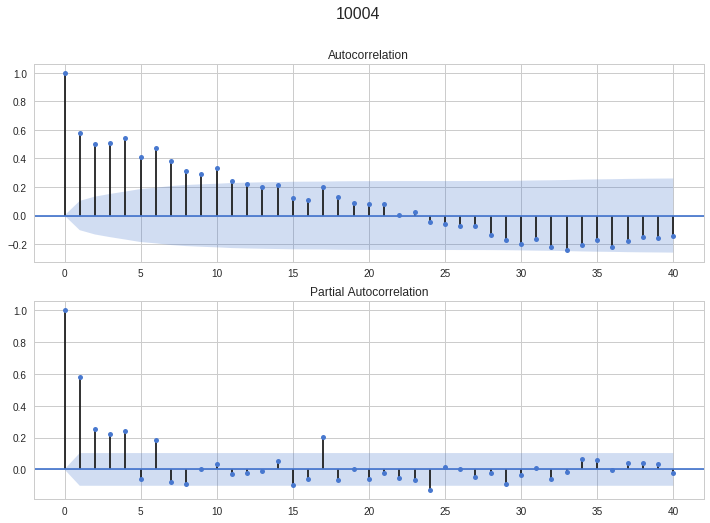

In [56]:
for _,ts in data.iteritems():
#自己相関
    ts_acf = sm.tsa.stattools.acf(ts, nlags=40)
    #print("ts_acf:",ts_acf)

# 偏自己相関
    ts_pacf = sm.tsa.stattools.pacf(ts, nlags=40, method='ols')
    #print("ts_pacf:",ts_pacf)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
    fig.suptitle(ts.name, fontsize=16)


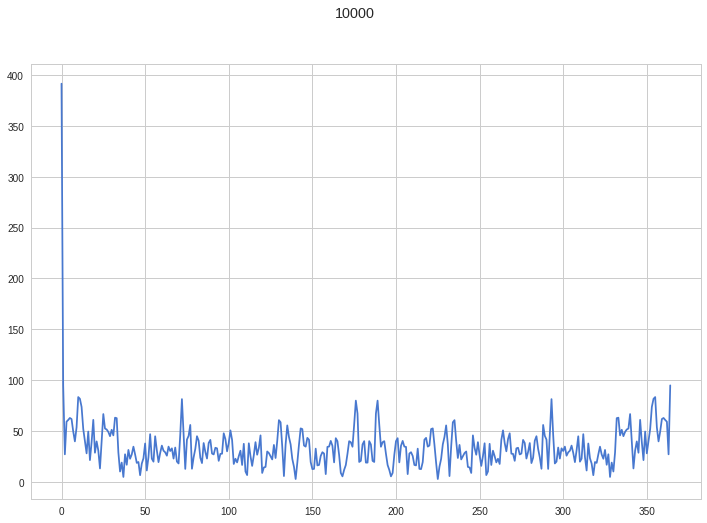

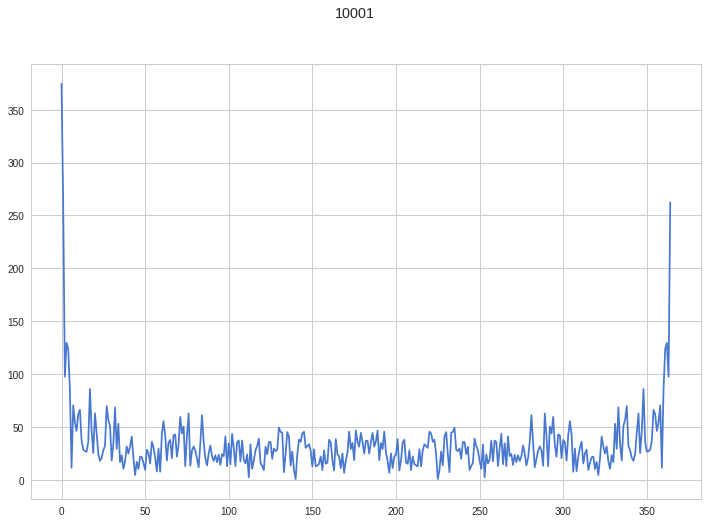

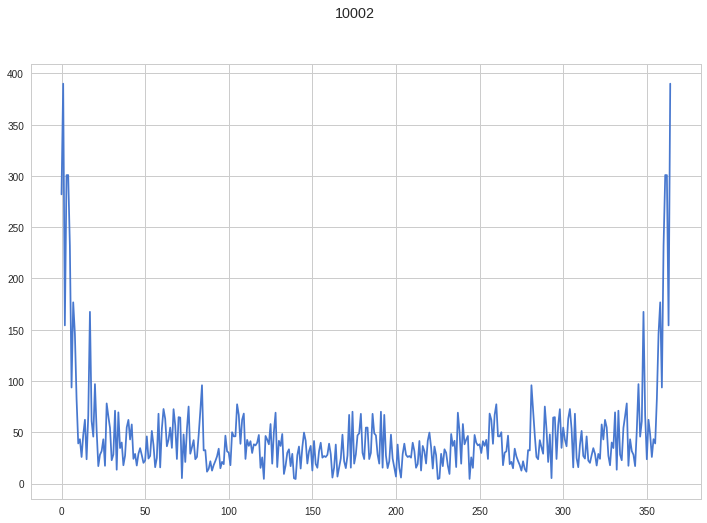

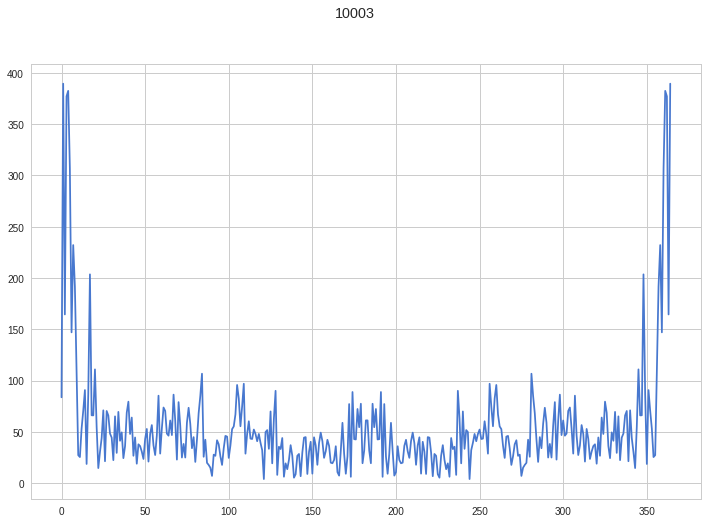

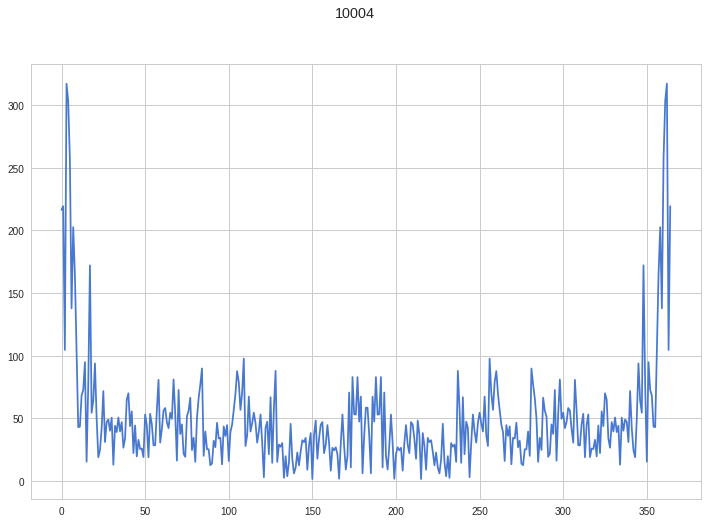

In [70]:
#周波数領域
#https://momonoki2017.blogspot.com/2018/03/pythonfft-1-fft.html
for _,f in data.iteritems():
    F = np.fft.fft(f)
    F_abs = np.abs(F)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(111)
    ax1.plot(F_abs)
    fig.suptitle(f.name)